In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

torch.random.manual_seed(0)

## Data: randomness

Deterministic transform

In [ ]:
from factorization.data.synthetic import (
    generate_transform,
    Factorizer,
    Sampler, 
    DirichletSampler,
    AggregatedSampler,
)


In [ ]:
input_size = 10
output_size = 5
sampler = Sampler(input_size, output_size)
print(sampler.probas)

tensor([[0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.]])


In [ ]:
# ilustrating the generating function
inputs = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 1, 2, 1, 1, 3,])
targets = sampler.generate_targets(inputs)
print(targets)

tensor([4, 4, 3, 0, 3, 4, 2, 3, 2, 3, 4, 4, 3, 4, 4, 0])


Sparse transform

In [ ]:
sparsity_index = 10
all_probas = [
    Sampler(input_size, output_size).probas for _ in range(sparsity_index)
]
sampler = AggregatedSampler(all_probas, epsilon=1e-3)
print(sampler.probas)

tensor([[4.9970e-01, 2.0000e-04, 1.0010e-01, 2.0000e-01, 2.0000e-01],
        [2.0000e-04, 2.0000e-01, 2.9990e-01, 3.9980e-01, 1.0010e-01],
        [2.9990e-01, 1.0010e-01, 2.9990e-01, 1.0010e-01, 2.0000e-01],
        [2.0000e-01, 2.9990e-01, 2.0000e-01, 2.9990e-01, 2.0000e-04],
        [2.0000e-04, 2.0000e-01, 2.0000e-01, 1.0010e-01, 4.9970e-01],
        [2.0000e-01, 2.0000e-01, 2.0000e-04, 2.0000e-01, 3.9980e-01],
        [1.0010e-01, 2.9990e-01, 1.0010e-01, 2.0000e-01, 2.9990e-01],
        [1.0010e-01, 1.0010e-01, 2.0000e-01, 1.0010e-01, 4.9970e-01],
        [3.9980e-01, 2.0000e-01, 2.0000e-01, 2.0000e-01, 2.0000e-04],
        [2.0000e-01, 1.0010e-01, 1.0010e-01, 2.0000e-01, 3.9980e-01]])


In [ ]:
tmp = sum(all_probas)
tmp /= input_size
tmp *= (1 - 1e-3)
tmp += 1e-3 / output_size
assert torch.allclose(tmp, sampler.probas)

Random transform

In [ ]:
alpha = 1
sampler = DirichletSampler(input_size, output_size, alpha)
print(sampler.probas)

tensor([[0.2649, 0.0625, 0.1046, 0.3650, 0.2031],
        [0.4859, 0.0046, 0.2810, 0.1338, 0.0947],
        [0.1982, 0.0459, 0.3593, 0.2103, 0.1864],
        [0.1445, 0.3282, 0.0426, 0.3749, 0.1098],
        [0.2558, 0.2781, 0.2610, 0.1473, 0.0579],
        [0.1019, 0.4135, 0.0127, 0.0185, 0.4534],
        [0.1891, 0.0014, 0.0172, 0.1071, 0.6852],
        [0.0548, 0.5081, 0.0892, 0.2946, 0.0533],
        [0.6038, 0.0844, 0.1579, 0.0968, 0.0570],
        [0.1845, 0.0112, 0.1306, 0.5585, 0.1152]])


## Data: Factorized relation

In [ ]:
# ps = torch.tensor([4, 6, 2, 5, 100, 3])
ps = torch.tensor([4, 6, 2, 5])
alpha = .5
qs = (alpha * ps).ceil().to(int)
print(qs)

max_x = ps.prod()
x = torch.linspace(0, max_x - 1, max_x - 1).to(int)

tensor([2, 3, 1, 3])


In [ ]:
x_factorizer = Factorizer(ps)
y_factorizer = Factorizer(qs)

factors = x_factorizer(x)
print(1 - (factors != 0).to(float).mean(axis=0))
print(1 / ps)

tensor([0.2510, 0.1674, 0.5021, 0.2008], dtype=torch.float64)
tensor([0.2500, 0.1667, 0.5000, 0.2000])


In [ ]:
transforms = [generate_transform(ps[i], qs[i]) for i in range(len(ps))]
transformed_factors = torch.zeros_like(factors)
for i in range(len(ps)):
    transformed_factors[:, i] = transforms[i][factors[:, i]]
y = y_factorizer.recomposition(transformed_factors)

tensor(True) tensor(True)


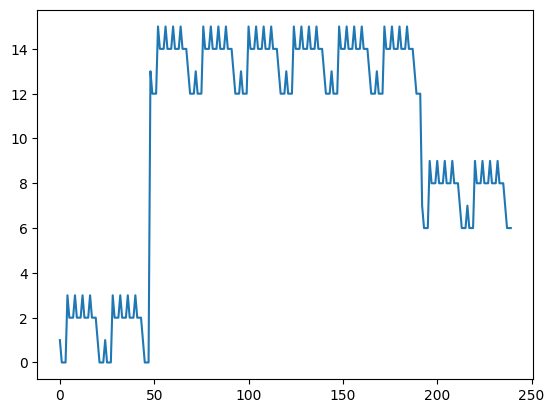

In [ ]:
x_tmp = x_factorizer.recomposition(factors)
y_transform = y_factorizer(y)
print((x_tmp == x).all(), (y_transform == transformed_factors).all())
plt.plot(x, y)

## Model

To keep it simple, I take a MLP architecture that resembles a transformer without attention.

In [ ]:
from factorization.models.mlp import ModelConfig, Model

In [ ]:
config = ModelConfig(
    input_size=max_x,
    output_size=torch.max(y) + 1,
    emb_dim=32,
    ffn_dim=64,
    nb_layers=2,
)

model = Model(config)

## training

In [ ]:
n_epochs = 1000
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=.01)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

losses = torch.empty(n_epochs)

inputs = x
outputs = y

# min_loss = F.cross_entropy(torch.log(targets), targets).item()
min_loss = 0

model.to(device)
inputs = inputs.to(device)
targets = outputs.to(device)

for epoch in range(n_epochs):
    # training

    logits = model(inputs)
    loss = F.cross_entropy(logits, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses[epoch] = loss.item() - min_loss

[]

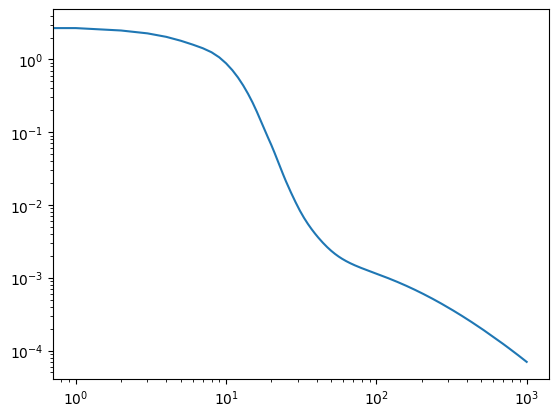

In [ ]:
plt.plot(losses)
plt.loglog()